<a href="https://colab.research.google.com/github/yiihuang/Deep_Learning/blob/master/simple_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Main imports**

In [ ]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import sleep

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Import dataset**

In [ ]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
    ])),
shuffle=True, batch_size=64, drop_last=True)

img_width = 28
n_channels = 1
train_iterator = iter(cycle(train_loader))
print(f'> Size of training dataset {len(train_loader.dataset)}')

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!
> Size of training dataset 60000


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


**View some of the test dataset**

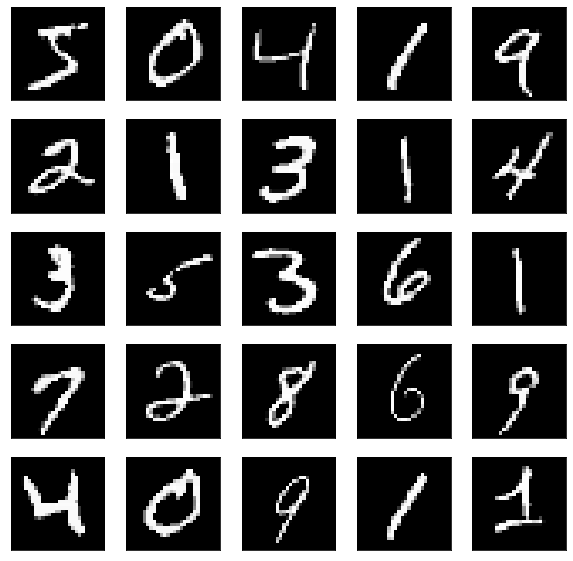

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if n_channels == 1:
        plt.imshow(train_loader.dataset[i][0].clamp(0,1).repeat(3,1,1).permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)

**Define two models: (1) Generator, and (2) Discriminator**

In [ ]:
# define the model
class Generator(nn.Module):
    def __init__(self, latent_size=100):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(latent_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, n_channels*img_width*img_width),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.layer(x)
        x = x.view(x.size(0), n_channels, img_width, img_width)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(n_channels*img_width*img_width, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1), # 1 output for real/fake
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layer(x)
        return x

G = Generator().to(device)
D = Discriminator().to(device)

print(f'> Number of generator parameters {len(torch.nn.utils.parameters_to_vector(G.parameters()))}')
print(f'> Number of discriminator parameters {len(torch.nn.utils.parameters_to_vector(D.parameters()))}')

# initialise the optimiser
optimiser_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimiser_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
bce_loss = nn.BCELoss()
epoch = 0

> Number of generator parameters 1510032
> Number of discriminator parameters 533505


**Main training loop**

loss d: 0.806, loss g: 0.648


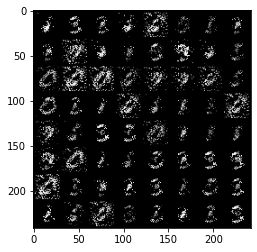

loss d: 0.895, loss g: 0.608


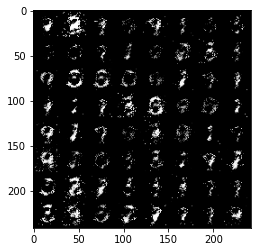

loss d: 0.914, loss g: 0.571


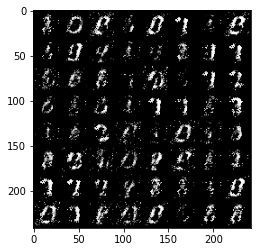

loss d: 0.931, loss g: 0.534


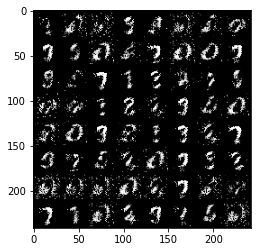

loss d: 1.071, loss g: 0.476


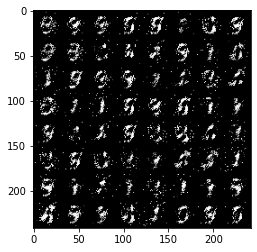

loss d: 1.243, loss g: 0.428


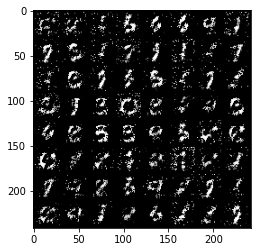

loss d: 1.318, loss g: 0.405


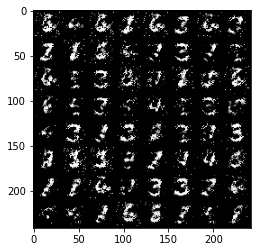

loss d: 1.344, loss g: 0.386


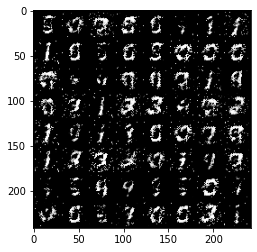

loss d: 1.459, loss g: 0.367


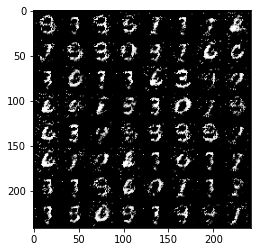

loss d: 1.310, loss g: 0.383


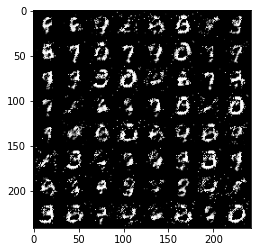

loss d: 1.277, loss g: 0.398


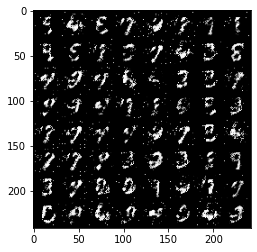

loss d: 1.322, loss g: 0.373


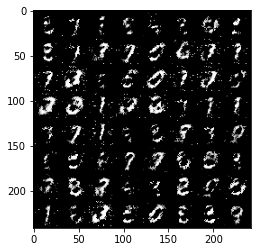

loss d: 1.263, loss g: 0.394


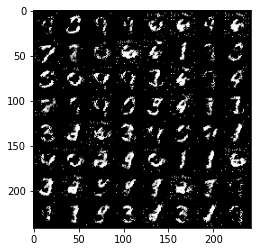

loss d: 1.237, loss g: 0.394


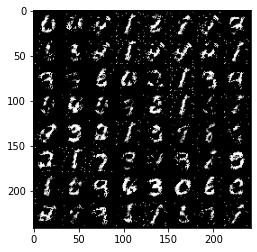

loss d: 1.245, loss g: 0.412


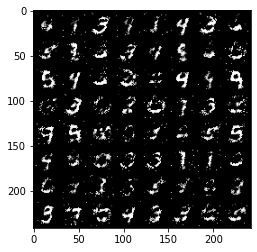

loss d: 1.206, loss g: 0.426


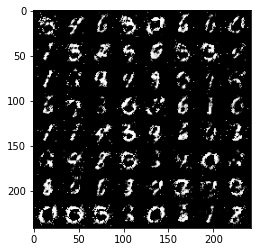

loss d: 1.120, loss g: 0.444


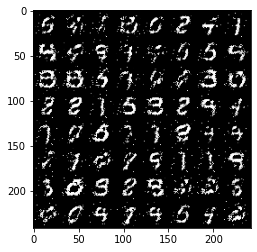

loss d: 0.883, loss g: 0.602


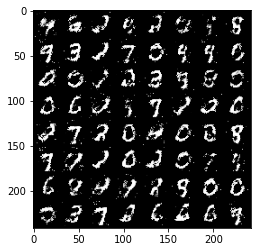

loss d: 1.005, loss g: 0.491


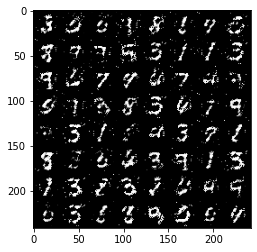

loss d: 1.019, loss g: 0.483


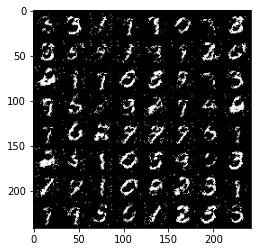

In [ ]:
# training loop
while (epoch<20):

    # arrays for metrics
    logs = {}
    gen_loss_arr = np.zeros(0)
    dis_loss_arr = np.zeros(0)

    # iterate over some of the train dateset
    for i in range(500):
        x,t = next(train_iterator)
        x,t = x.to(device), t.to(device)

        # train discriminator
        g = G(torch.randn(x.size(0), 100).to(device))
        l_r = bce_loss(D(x).mean(), torch.ones(1)[0].to(device)) # real -> 1
        l_f = bce_loss(D(g.detach()).mean(), torch.zeros(1)[0].to(device)) #  fake -> 0
        loss_d = (l_r + l_f)/2.0
        optimiser_D.zero_grad()
        loss_d.backward()
        optimiser_D.step()

        # train generator
        g = G(torch.randn(x.size(0), 100).to(device))
        loss_g = bce_loss(D(g).mean(), torch.ones(1)[0].to(device)) # fake -> 1
        optimiser_G.zero_grad()
        loss_g.backward()
        optimiser_G.step()

        gen_loss_arr = np.append(gen_loss_arr, loss_g.item())
        dis_loss_arr = np.append(dis_loss_arr, loss_d.item())

    # plot some examples
    G.eval()
    g = G(torch.randn(x.size(0), 100).to(device))
    print('loss d: {:.3f}, loss g: {:.3f}'.format(gen_loss_arr.mean(), dis_loss_arr.mean()))
    plt.grid(False)
    plt.imshow(torchvision.utils.make_grid(g).cpu().data.clamp(0,1).permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    plt.show()
    plt.pause(0.0001)
    G.train()

    epoch = epoch+1